In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sb  
import random
%matplotlib inline

In [2]:
file_path = 'data/gapminder_under5mortality.csv'
child_mortality_df = pd.read_csv(file_path, index_col = 0)
child_mortality_df.index.names = ['country']
child_mortality_df.columns.names = ['year']
child_mortality_df.shape

(440, 216)

In [3]:
child_mortality_df.head()

year,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
country,,,,,,,,,,,,,,,,,,,,,
Abkhazia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Afghanistan,468.58,468.58,468.58,468.58,468.58,468.58,469.98,469.98,469.98,469.98,...,116.3,113.2,110.4,107.6,105.0,102.3,99.5,96.7,93.9,91.1
Akrotiri and Dhekelia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Albania,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,...,19.5,18.7,17.9,17.3,16.6,16.0,15.5,14.9,14.4,14.0
Algeria,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,...,32.1,30.7,29.5,28.4,27.4,26.6,25.8,25.2,24.6,24.0


Clean data, remove countiry with missing or no information.

In [4]:
child_mortality_clean = child_mortality_df.dropna()
#child_mortality_clean = child_mortality_clean.drop(child_mortality_clean.columns[[i for i in range(0,100)]], axis=1)  # df.columns is zero-based pd.Index 


In [5]:
child_mortality_clean.head()

year,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,468.58,468.58,468.58,468.58,468.58,468.58,469.98,469.98,469.98,469.98,...,116.3,113.2,110.4,107.6,105.0,102.3,99.5,96.7,93.9,91.1
Albania,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,...,19.5,18.7,17.9,17.3,16.6,16.0,15.5,14.9,14.4,14.0
Algeria,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,...,32.1,30.7,29.5,28.4,27.4,26.6,25.8,25.2,24.6,24.0
Angola,485.68,485.68,485.68,485.68,485.68,485.68,485.68,485.68,485.68,485.68,...,200.5,196.4,192.0,187.3,182.5,177.3,172.2,167.1,162.2,156.9
Antigua and Barbuda,473.60,469.77,465.97,462.20,458.47,454.76,451.08,447.43,443.82,440.23,...,11.8,11.3,10.9,10.4,9.9,9.5,9.1,8.7,8.4,8.1


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

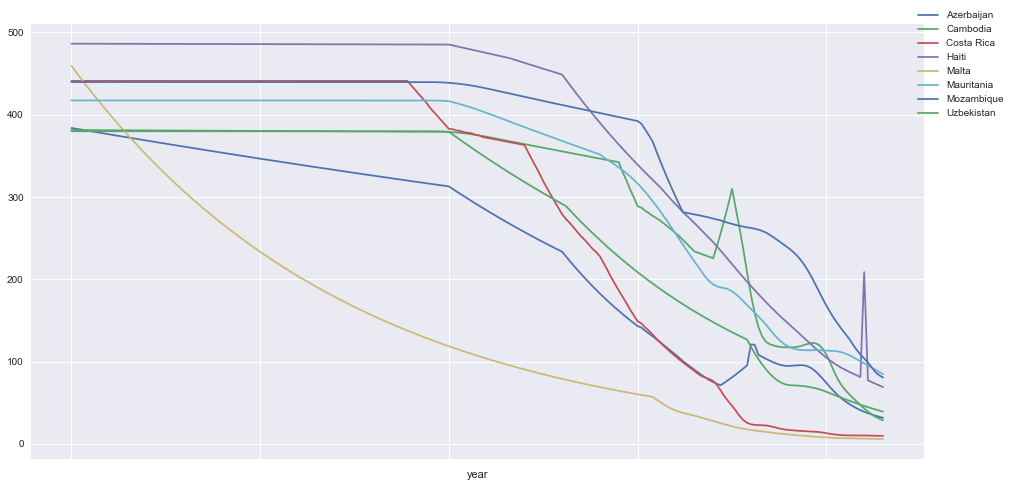

In [7]:
labels = []


fig = plt.figure()
ax = plt.subplot(111)
for i in range(child_mortality_clean.shape[0]):
    plot = random.randint(0, 100)
    if plot<5:
        child_mortality_clean.iloc[i].plot(figsize=(16,8))
        labels.append(child_mortality_clean.index[i])
    plt.legend(labels);
ax.legend(bbox_to_anchor=(1.1, 1.05))


Implementing PCA

In [8]:
from  sklearn.decomposition  import PCA

pca = PCA(n_components=4)
pca.fit(child_mortality_clean)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [9]:
child_mortality_4D = pca.transform(child_mortality_clean)
print(pca.explained_variance_ratio_)

[0.76831065 0.12479226 0.03627298 0.02262252]


In [10]:
child_mortality_PC_df = pd.DataFrame(child_mortality_4D)
child_mortality_PC_df.index = child_mortality_clean.index
child_mortality_PC_df.columns = ['PC1','PC2','PC3','PC4']
child_mortality_PC_df.head()

,PC1,PC2,PC3,PC4
country,,,,
Afghanistan,-1640.962019,-433.084866,113.775000,46.322522
Albania,275.775641,80.866800,-277.642172,-160.617319
Algeria,-914.671217,132.754213,-51.810449,131.642385
Angola,-1658.840597,-405.102842,293.550760,-56.821857
Antigua and Barbuda,1481.556193,-354.894205,69.464114,340.838996


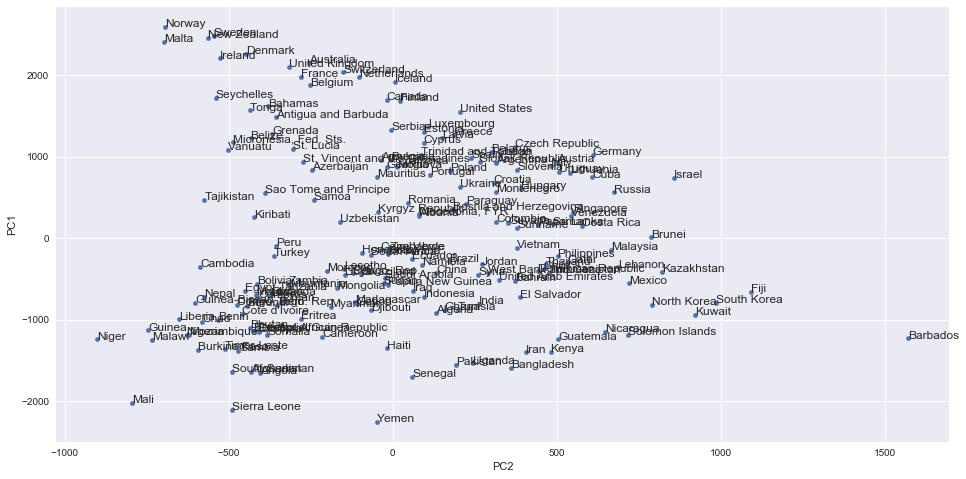

In [11]:
ax = child_mortality_PC_df.plot(kind='scatter', x='PC2', y='PC1', figsize=(16,8))

for i, country in enumerate(child_mortality_PC_df.index):
    ax.annotate(country, (child_mortality_PC_df.iloc[i].PC2, child_mortality_PC_df.iloc[i].PC1))

In [12]:
from sklearn.preprocessing import normalize

child_mortality_clean['country_mean'] = pd.Series(child_mortality_clean.mean(axis=1), index=child_mortality_clean.index)
country_mean_max = child_mortality_clean['country_mean'].max()
country_mean_min = child_mortality_clean['country_mean'].min()
country_mean_scaled = (child_mortality_clean.country_mean-country_mean_min) / country_mean_max
child_mortality_PC_df['country_mean_scaled'] = pd.Series(country_mean_scaled, index=child_mortality_clean.index)
child_mortality_PC_df.head()

/Users/camilarangelsmith/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,PC1,PC2,PC3,PC4,country_mean_scaled
country,,,,,
Afghanistan,-1640.962019,-433.084866,113.775000,46.322522,0.622810
Albania,275.775641,80.866800,-277.642172,-160.617319,0.327422
Algeria,-914.671217,132.754213,-51.810449,131.642385,0.509410
Angola,-1658.840597,-405.102842,293.550760,-56.821857,0.642338
Antigua and Barbuda,1481.556193,-354.894205,69.464114,340.838996,0.178029


In [13]:
child_mortality_PC_df['country_change'] = pd.Series(child_mortality_clean['1900']-child_mortality_clean['2015'], index=child_mortality_clean.index)
country_change_max = child_mortality_PC_df['country_change'].max()
country_change_min = child_mortality_PC_df['country_change'].min()
country_change_scaled = (child_mortality_PC_df.country_change - country_change_min) / country_change_max
child_mortality_PC_df['country_change_scaled'] = pd.Series(country_change_scaled, index=child_mortality_PC_df.index)
child_mortality_PC_df[['country_change','country_change_scaled']].head()

,country_change,country_change_scaled
country,,
Afghanistan,390.67,0.444650
Albania,360.39,0.398409
Algeria,435.21,0.512667
Angola,327.73,0.348533
Antigua and Barbuda,202.18,0.156804


In [14]:
child_mortality_PC_df['country_change_recent'] = pd.Series(child_mortality_clean['1900']-child_mortality_clean['2015'], index=child_mortality_clean.index)
country_change_max = child_mortality_PC_df['country_change_recent'].max()
country_change_min = child_mortality_PC_df['country_change_recent'].min()
country_change_scaled = (child_mortality_PC_df.country_change - country_change_min) / country_change_max
child_mortality_PC_df['country_change_recent_scaled'] = pd.Series(country_change_scaled, index=child_mortality_PC_df.index)
child_mortality_PC_df[['country_change_recent','country_change_recent_scaled']].head()

,country_change_recent,country_change_recent_scaled
country,,
Afghanistan,390.67,0.444650
Albania,360.39,0.398409
Algeria,435.21,0.512667
Angola,327.73,0.348533
Antigua and Barbuda,202.18,0.156804


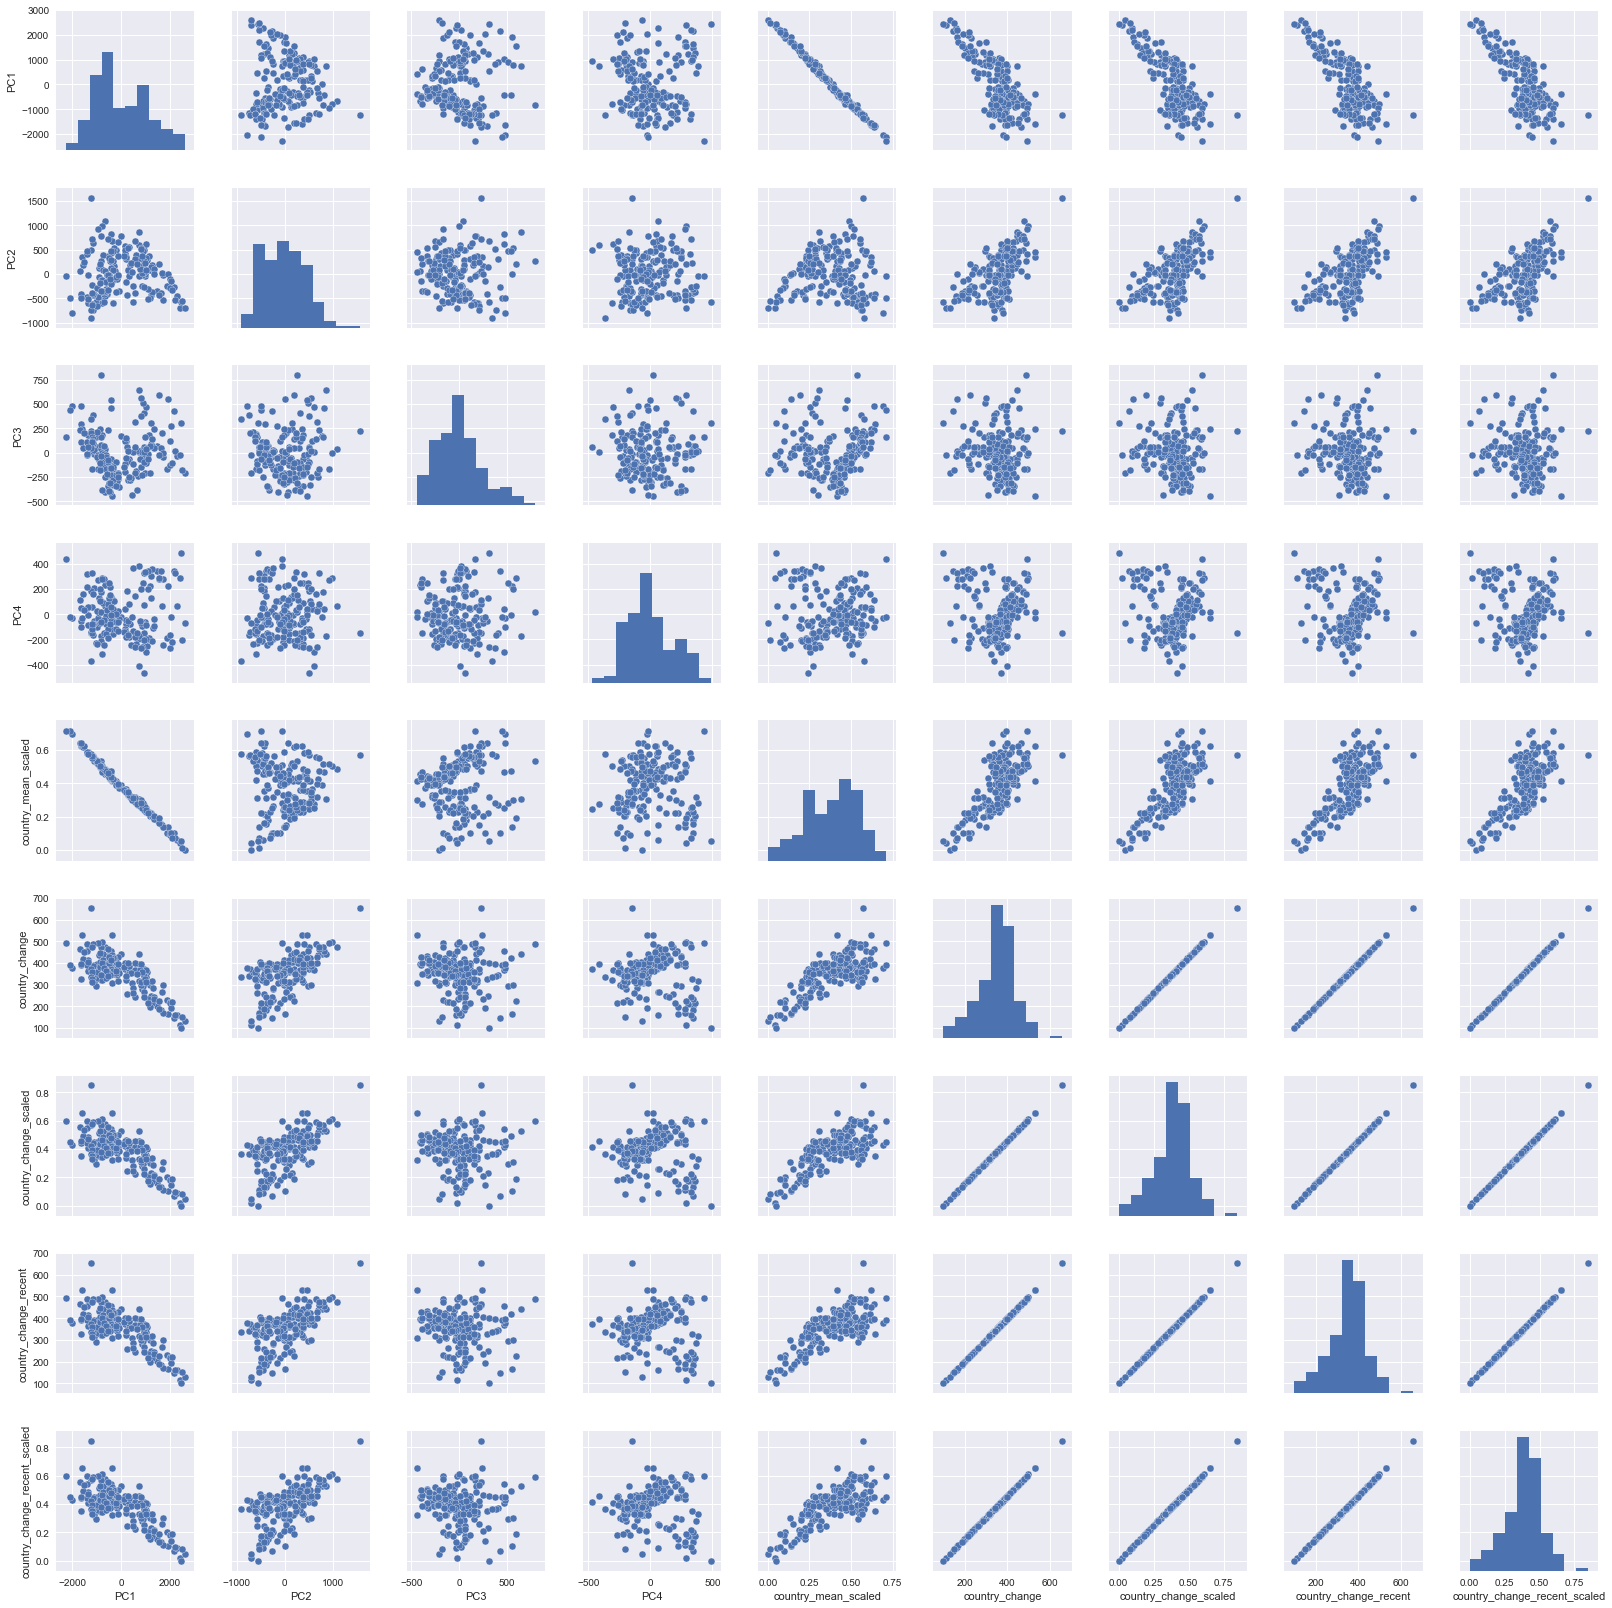

In [15]:
seaborn.pairplot(child_mortality_PC_df)

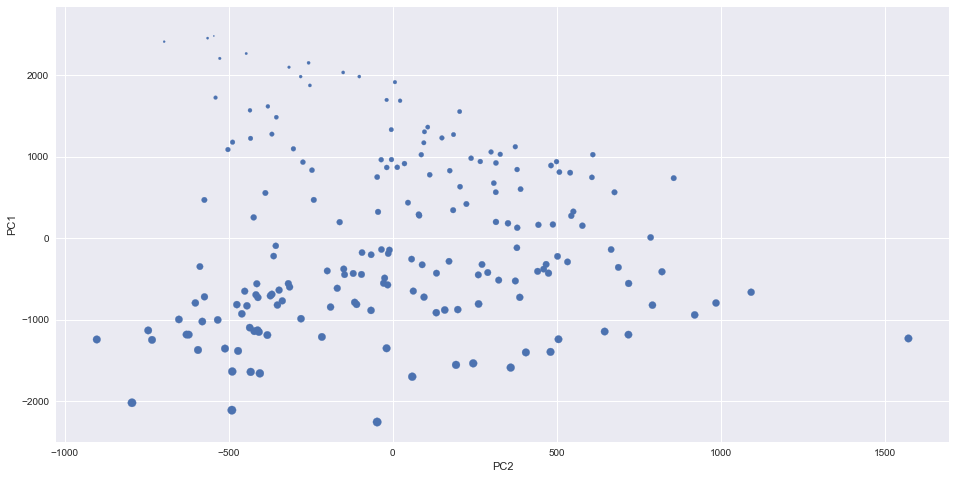

In [16]:
child_mortality_PC_df.plot(kind='scatter', x='PC2', y='PC1', s=child_mortality_PC_df['country_mean_scaled']*100, figsize=(16,8))

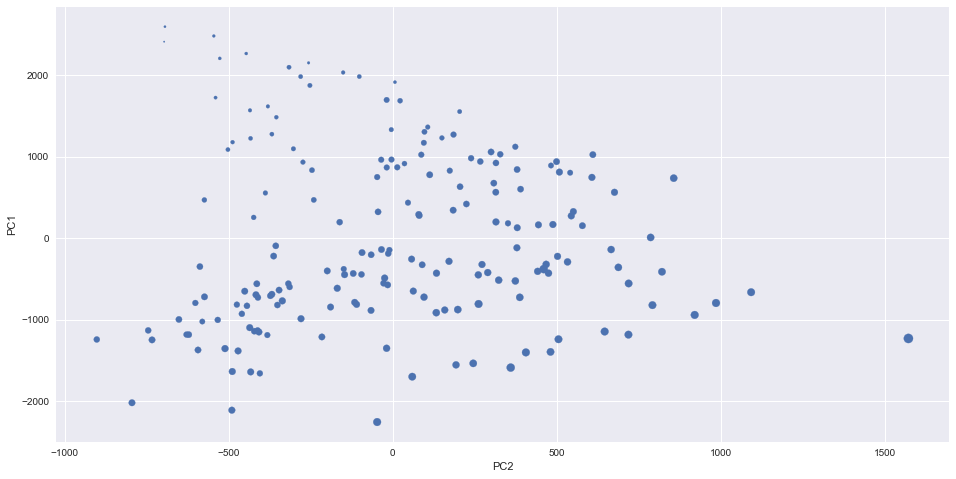

In [17]:
child_mortality_PC_df.plot(kind='scatter', x='PC2', y='PC1', s=child_mortality_PC_df['country_change_scaled']*100, figsize=(16,8))

In [57]:
from  sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)

clusters = kmeans.fit(child_mortality_PC_df[['PC1','PC2','PC3','PC4']])

In [77]:
child_mortality_PC_df['cluster'] = pd.Series(clusters.labels_, index=child_mortality_PC_df.index)
child_mortality_clean['cluster'] = pd.Series(clusters.labels_, index=child_mortality_clean.index)

child_mortality_clean.head()

/Users/camilarangelsmith/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


year,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,...,2008,2009,2010,2011,2012,2013,2014,2015,country_mean,cluster
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,468.58,468.58,468.58,468.58,468.58,468.58,469.98,469.98,469.98,469.98,...,110.4,107.6,105.0,102.3,99.5,96.7,93.9,91.1,400.369907,1
Albania,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,...,17.9,17.3,16.6,16.0,15.5,14.9,14.4,14.0,270.369120,0
Algeria,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,...,29.5,28.4,27.4,26.6,25.8,25.2,24.6,24.0,350.462222,2
Angola,485.68,485.68,485.68,485.68,485.68,485.68,485.68,485.68,485.68,485.68,...,192.0,187.3,182.5,177.3,172.2,167.1,162.2,156.9,408.963935,1
Antigua and Barbuda,473.60,469.77,465.97,462.20,458.47,454.76,451.08,447.43,443.82,440.23,...,10.9,10.4,9.9,9.5,9.1,8.7,8.4,8.1,204.621065,3


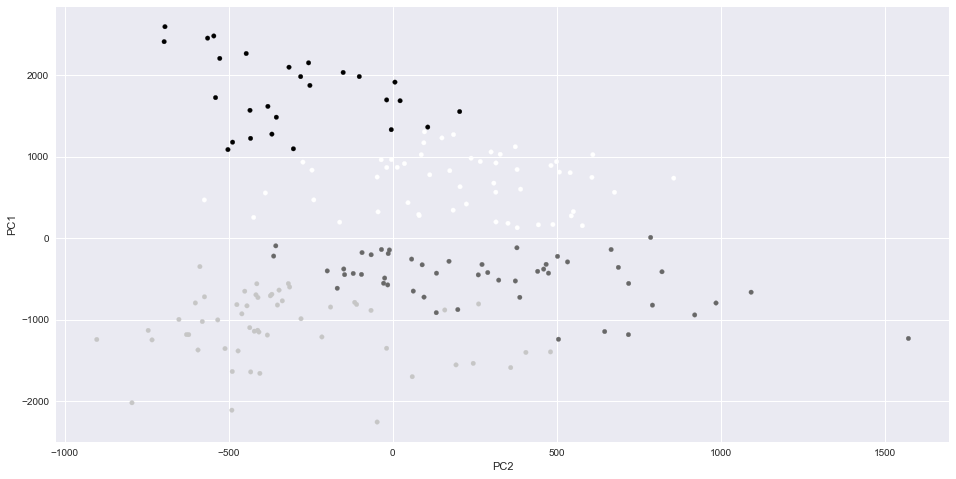

In [75]:
import numpy as np

child_mortality_PC_df.plot(
    kind='scatter',
    x='PC2',y='PC1',
    c=child_mortality_PC_df.cluster.astype(np.float), 
    figsize=(16,8))

In [78]:
child_mortality_PC_df_cluster0= child_mortality_clean[child_mortality_clean['cluster']==0]
child_mortality_PC_df_cluster1= child_mortality_clean[child_mortality_clean['cluster']==1]
child_mortality_PC_df_cluster2= child_mortality_clean[child_mortality_clean['cluster']==2]
child_mortality_PC_df_cluster3= child_mortality_clean[child_mortality_clean['cluster']==3]
#child_mortality_PC_df_cluster4= child_mortality_PC_df[child_mortality_PC_df['cluster']==4]

child_mortality_PC_df_cluster4.index

Index([], dtype='object', name=u'country')

In [61]:
def timeseries_for_countries(selected_countries):

    labels = []

    fig = plt.figure()
    ax = plt.subplot(111)
    for i in range(child_mortality_clean.shape[0]):
        plot = random.randint(0, 100)
        if child_mortality_clean.index[i] in selected_countries:
            child_mortality_clean.iloc[i].plot(figsize=(16,8))
            labels.append(child_mortality_clean.index[i])
        plt.legend(labels);
    ax.legend(bbox_to_anchor=(1.1, 1.05))

In [85]:
def timeseries_for_countries(cluster_df):
    cluster_df.loc['mean'] = cluster_df.mean()
    cluster_df.iloc[-1].plot(figsize=(16,8))


/Users/camilarangelsmith/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


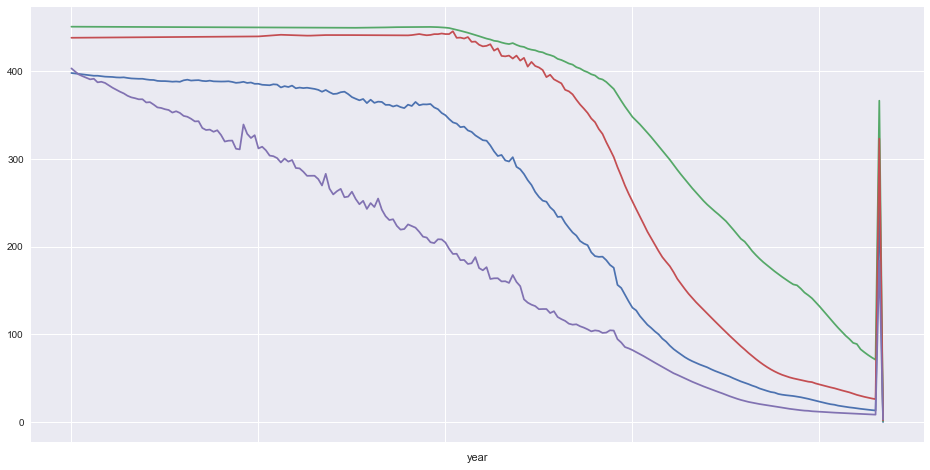

In [86]:
timeseries_for_countries(child_mortality_PC_df_cluster0)
timeseries_for_countries(child_mortality_PC_df_cluster1)
timeseries_for_countries(child_mortality_PC_df_cluster2)
timeseries_for_countries(child_mortality_PC_df_cluster3)

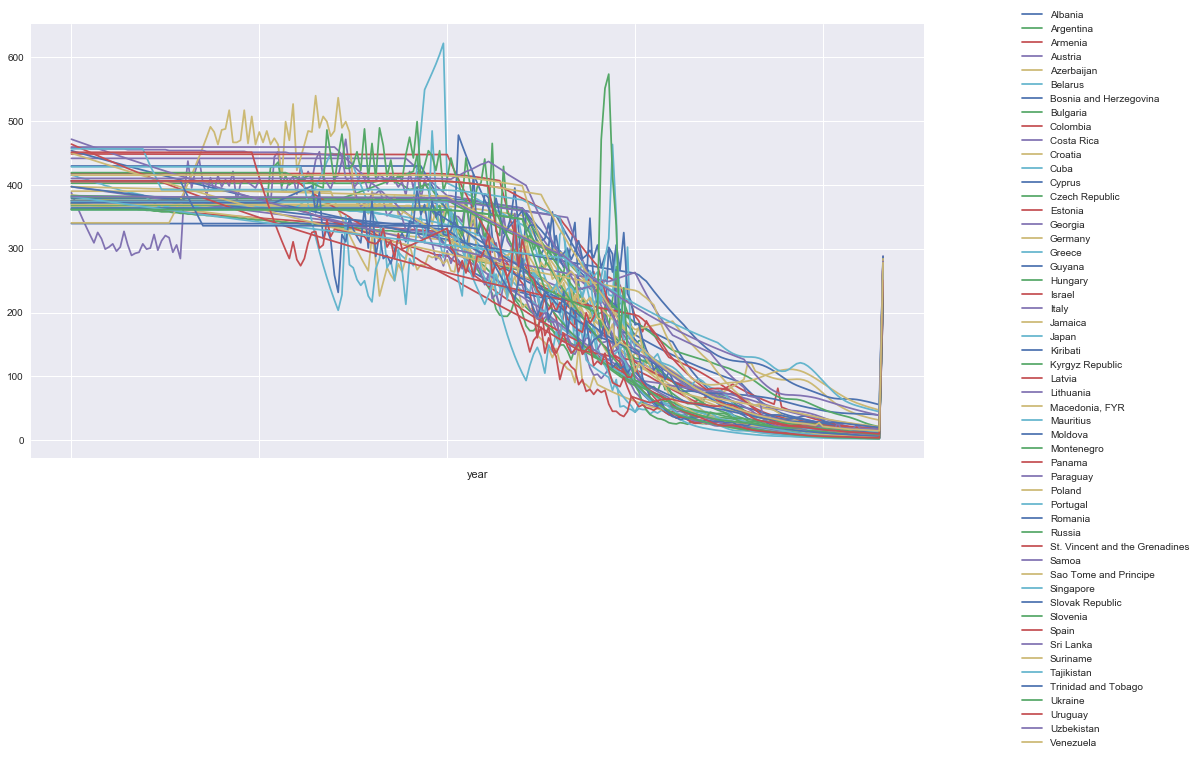

In [62]:
timeseries_for_countries(child_mortality_PC_df_cluster0.index)

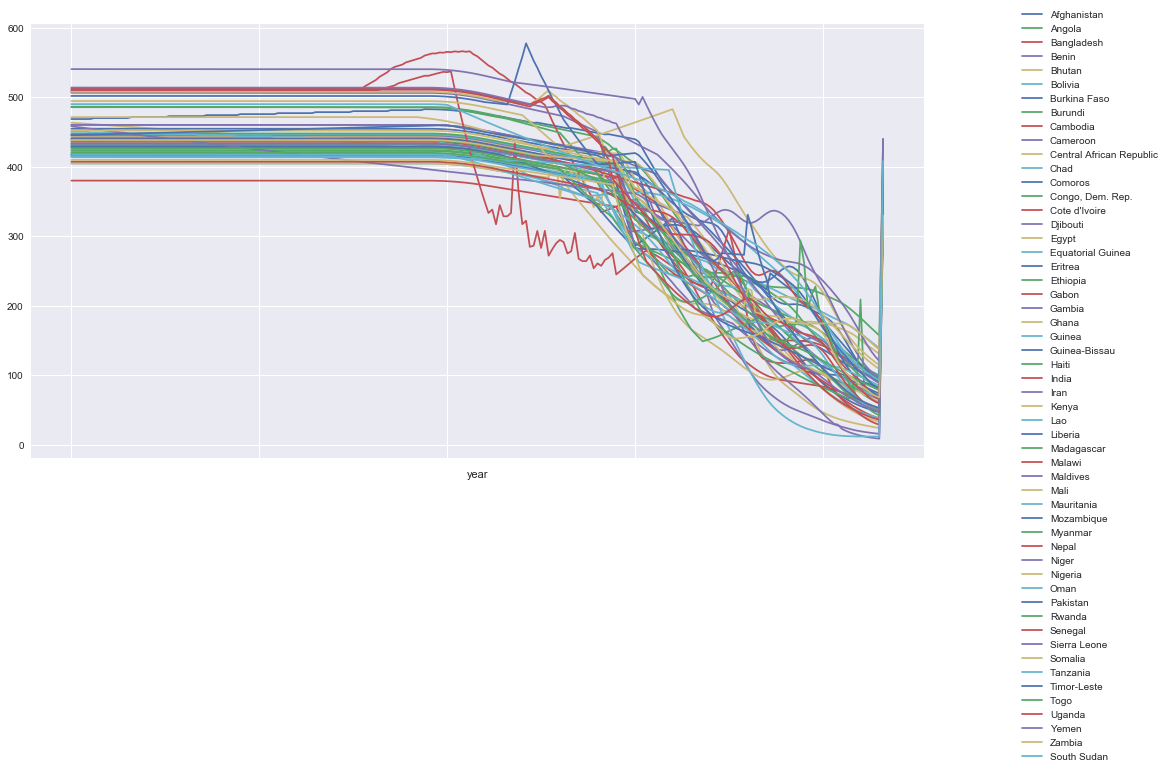

In [63]:
timeseries_for_countries(child_mortality_PC_df_cluster1.index)

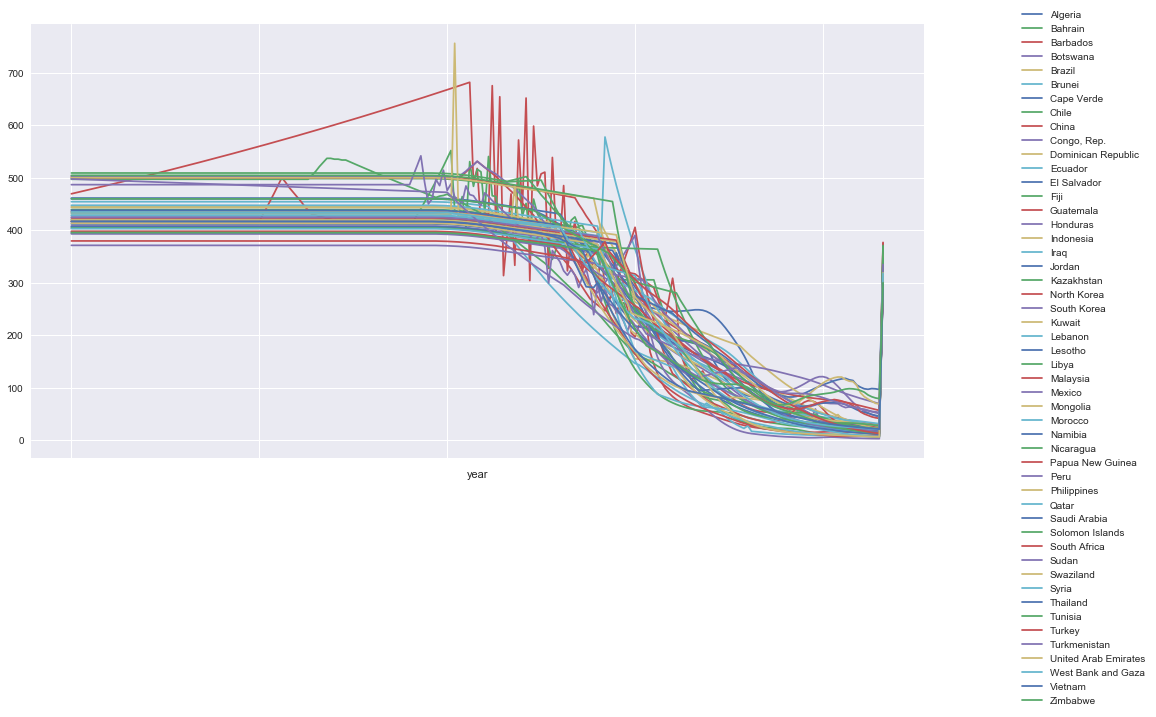

In [67]:
timeseries_for_countries(child_mortality_PC_df_cluster2.index)

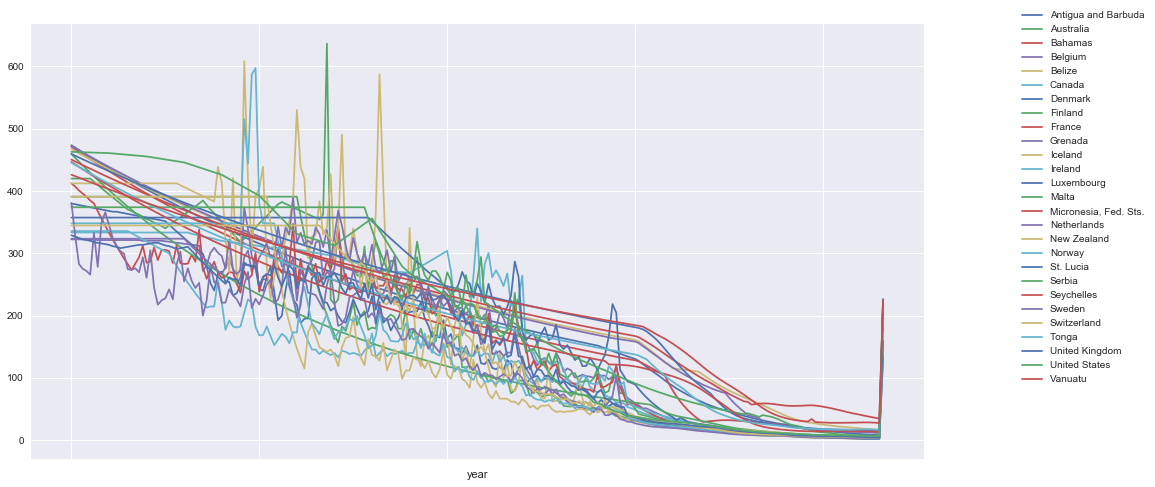

In [68]:
timeseries_for_countries(child_mortality_PC_df_cluster3.index)